# Tracing a RAG Application

![Simple RAG](../images/simple_rag.png)

In this notebook, we're going to set up a simple RAG application that we'll be using to learn about tracing.

RAG (Retrieval Augmented Generation) is a popular technique for providing LLMs with relevant documents that will enable them to better answer questions from users. In our case, we are going to index some LangSmith documentation!

LangSmith makes it easy to trace any LLM application, no LangChain required!

### Setup

Make sure you set your environment variables, including your OpenAI API key.

In [1]:
# Using a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

True

### Simple RAG application

We create a simple RAG application whose key functions have been wrapped with the traceable decorator. Adding the traceable decorator sends the inputs and outputs of the decorated function to LangSmith

In [2]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(run_type="llm")
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|#########################| 194/194 [00:07<00:00, 27.28it/s]


This should take a little less than a minute. We are indexing and storing LangSmith documentation in a SKLearn vector database.

In [3]:
question = "What is LangSmith used for?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"website": "www.google.com"}})
print(ai_answer)

LangSmith is a platform for building production-grade LLM applications, allowing users to monitor and evaluate their applications effectively. It provides features for observability, evaluation, and prompt engineering, facilitating quick and confident deployment. Additionally, it is framework-agnostic, compatible with or without LangChain's open-source frameworks.


#### Let's take a look in LangSmith!

### Tracing LangGraph or LangChain

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables. Let's implement the same RAG application using LangGraph!

![AWTT](../images/alternative_ways_to_trace_1.png)

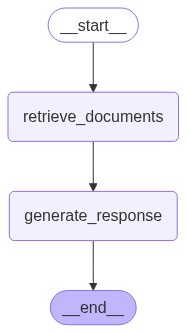

In [4]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

Let's now run our graph. Note that we can add metadata in our run that will automatically be traced to LangSmith as well

In [5]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"type": "graph"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, first install the necessary libraries, including LangGraph and the OpenAI integration. Then, configure your environment by setting the `LANGSMITH_TRACING` and `LANGSMITH_API_KEY` environment variables, along with your OpenAI API key. Finally, log a trace by calling LangChain runnables as normal, and LangSmith will infer the proper tracing configuration.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 673, 'total_tokens': 755, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'syste